<a href="https://colab.research.google.com/github/flying-bear/Style-Transfer/blob/main/ArtGAN_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Once Block (mostly for colab) 

## Install libraries

In [ ]:
from IPython.display import clear_output 

!pip install wandb
!pip install pytorch_lightning
clear_output()

## Download Data

In [ ]:
# Download to Colab from YaDisk
from IPython.display import clear_output 
import os, sys, json
import urllib.parse as ul
import pathlib

# Delete Colab folder with files
# import shutil
# shutil.rmtree(dest, ignore_errors=True)

def download_from_yadisk(url, path):
  """Download from yadisk by link like 'https://disk.yandex.com/d/20pYBTBAKTQo-w'"""
  base_url = 'https://cloud-api.yandex.net:443/v1/disk/public/resources/download?public_key='
  pathlib.Path(path).mkdir(exist_ok=True, parents=True) 

  res = os.popen('wget -qO - {}{}'.format(base_url, url)).read()
  json_res = json.loads(res)
  filename = ul.parse_qs(ul.urlparse(json_res['href']).query)['filename'][0]
  os.system("wget '{}' -P '{}' -O '{}'".format(json_res['href'], path, filename))

  !unzip -j $filename -d $path 
  clear_output()

In [ ]:
# download_from_yadisk('https://disk.yandex.ru/d/9krdOJ-FhNegSA', 'dataset/landscape')
download_from_yadisk('https://disk.yandex.ru/d/GNz40yoicS9GCg', 'dataset/owengent-hr')
download_from_yadisk('https://disk.yandex.ru/d/M9gq8P4lKT0ohQ', 'dataset/div2k')

In [ ]:
download_from_yadisk('https://disk.yandex.ru/d/qtvtZxOIOtjlkw', 'test_data')

In [ ]:
import tqdm

def preprocess_dataset(input_path, output_path, transform):
  input_path = pathlib.Path(input_path)
  output_path = pathlib.Path(output_path)
  output_path.mkdir(exist_ok=True, parents=True)
  for file in tqdm.tqdm(list(input_path.iterdir())):
      image = cv2.imread(str(file))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      save_image(transform(image), output_path / file.name)

In [ ]:
import torchvision.transforms as T
import cv2
from torchvision.utils import save_image

SIZE = 512 

transform = T.Compose([
  T.ToTensor(),
  T.Resize(SIZE),
])

preprocess_dataset('dataset/div2k','dataset/div2k-prp', transform)
preprocess_dataset('dataset/owengent-hr','dataset/owenget-hr-prp', transform)

100%|██████████| 113/113 [00:28<00:00,  3.97it/s]


# Imports and General Functions

In [ ]:
# More informative CUDA errors
# %env CUDA_LAUNCH_BLOCKING=1

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.utils import save_image

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule

In [ ]:
import datetime
import pathlib
import uuid

if IN_COLAB:
  drive.mount('/content/drive')
  checkpoints_path = pathlib.Path('/content/drive/MyDrive/style-transfer/checkpoints')
  checkpoints_path.mkdir(exist_ok=True, parents=True)


def get_timecoded_name(model):
  time_code = datetime.datetime.now().strftime("%y%m%d-%H%M%S") 
  model_name = model.__class__.__name__
  return model_name + '-' + time_code 


def get_file_size_mb(path):
  return path.stat().st_size / 1024 / 1024


def save_checkpoint(model, path=checkpoints_path):
  name = get_timecoded_name(model) + '.pth'
  path = pathlib.Path(path) / name
  torch.save(model.state_dict(), str(path))
  print(f'>> {str(path)} | {get_file_size_mb(path):.2f} MB')

In [ ]:
def load_image(path='exms/1.jpg'):
    transform = T.Compose([
      T.ToTensor(),
      T.ConvertImageDtype(torch.float),
    ])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    return image

def render(image, size=(16, 16)):
    fig = plt.figure(figsize=size)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Datasets

In [ ]:
class RandomCropsDataset(Dataset):
  def __init__(self, path, width=512, crop=(224, 224)):
    self.files = [str(file) for file in pathlib.Path(path).iterdir()]
    if width is not None:
      self.transform = T.Compose([
        T.ToTensor(),
        T.Resize(width),
        T.RandomCrop(crop),
        T.ConvertImageDtype(torch.float),
      ])
    else:
      self.transform = T.Compose([
        T.ToTensor(),
        # T.Resize(width),
        T.RandomCrop(crop),
        T.ConvertImageDtype(torch.float),
      ])

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    try:
      image = cv2.imread(self.files[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0
    except:
      print(f'failed to read {self.files[idx]}')
      image = cv2.imread(self.file[0])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return self.transform(image), 0


class ContentStyleDataset(Dataset):
  """Return a random pair of (content, style)""" 
  def __init__(self, content_dataset, style_dataset, pairs_per_epoch=1000):
    self.content = content_dataset 
    self.style = style_dataset 
    self.size = pairs_per_epoch 

  def __len__(self):
    return self.size 

  def __getitem__(self, idx):
    i = np.random.randint(0, len(self.content))
    j = np.random.randint(0, len(self.style))
    content, _ = self.content[i]
    style, _ = self.style[j]
    return content, style

In [ ]:
def show_dataset(dataset, n=6):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=n, num_workers=0, shuffle=True)
  images, classes = next(iter(data_loader))
  fig = plt.figure(figsize=(16, 8))
  if len(classes.shape) == 1:
    plt.imshow(torch.cat([images[i] for i in range(n)], 2).permute(1, 2, 0))
  else:
    first_row = torch.cat([images[i] for i in range(n)], 2)
    second_row = torch.cat([classes[i] for i in range(n)], 2) 
    plt.imshow(torch.cat([first_row, second_row], 1).permute(1, 2, 0))
  plt.show()

## View datasets

In [ ]:
dataset_content = RandomCropsDataset('dataset/div2k-prp')
dataset_style = RandomCropsDataset('dataset/owenget-hr-prp')

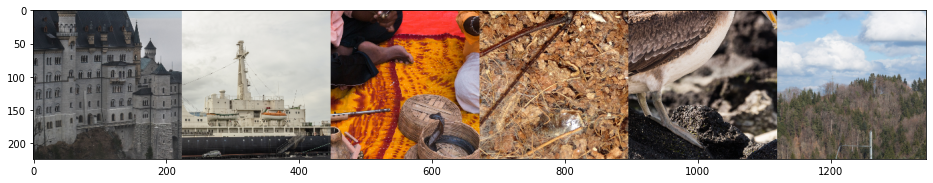

In [ ]:
show_dataset(dataset_content)

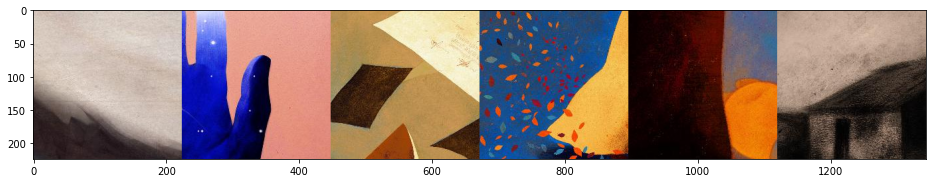

In [ ]:
show_dataset(dataset_style)

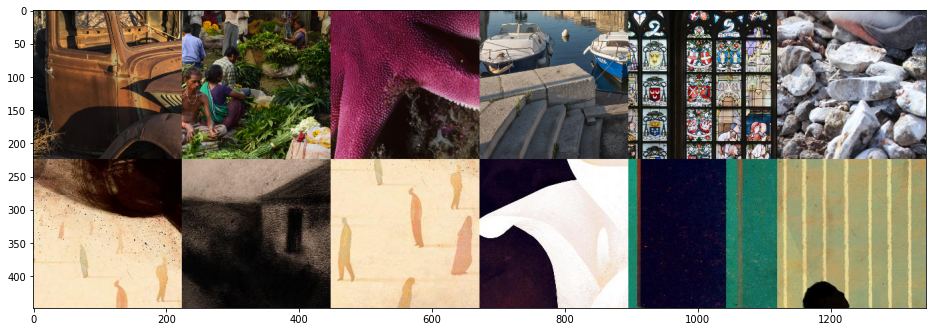

In [ ]:
dataset = ContentStyleDataset(content_dataset=dataset_content, 
                              style_dataset=dataset_style, 
                              pairs_per_epoch=1000)

show_dataset(dataset)

# External Logging (wandb.ai)

In [ ]:
key = input()
entity = input()

In [ ]:
import wandb

wandb.login(key=key)
wandb.init(project="artgan", entity=entity)

In [ ]:
## Download checkpoint

# file = wandb.restore('tmp.pth', run_path= entity + '/my-test-project/2kusm53f')
# wandb.finish()

# A Style-Aware Content Loss for Real-time HD Style Transfer

## Description

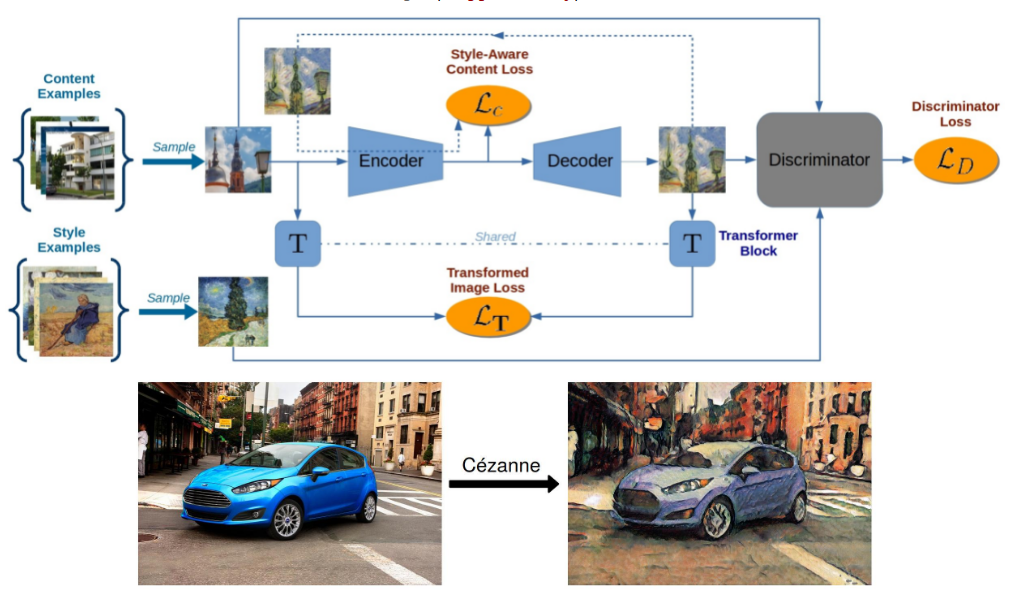

https://compvis.github.io/adaptive-style-transfer/

## Model

### Discriminator

In [ ]:
class DiscriminatorDownScaleBlock(nn.Module):
  def __init__(self, in_dim, out_dim):
    """
    d5-k-LReLU block from the paper
    shrink image exactly twice
    """
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, (5, 5), stride=2, padding=2, padding_mode='reflect'),
      nn.InstanceNorm2d(out_dim),
      nn.LeakyReLU(0.2, inplace=True),
    )  

  def forward(self, x):
    return self.net(x)

In [ ]:
class DiscriminatorClassifier(nn.Module):
  def __init__(self, in_dim, n_filters=3):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(in_dim, 1, (n_filters, n_filters)),
      nn.Flatten()
    )  

  def forward(self, x):
    return torch.mean(self.net(x), 1).unsqueeze(1)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    """
    d5-k-LReLU block from the paper
    shrink image exactly twice
    """
    super().__init__()
    self.depth_1 = DiscriminatorDownScaleBlock(3, 128)
    self.class_1 = DiscriminatorClassifier(128, 5)

    self.depth_2 = DiscriminatorDownScaleBlock(128, 128)
    self.class_2 = DiscriminatorClassifier(128, 10)

    self.depth_3 = DiscriminatorDownScaleBlock(128, 256)
    self.class_3 = DiscriminatorClassifier(256, 5)

    self.depth_4 = DiscriminatorDownScaleBlock(256, 512)
    self.class_4 = DiscriminatorClassifier(512, 5)

    self.depth_5 = DiscriminatorDownScaleBlock(512, 512)
    self.class_5 = DiscriminatorClassifier(512, 7)

  def forward(self, x):
    x_1 = self.depth_1(x)
    c_1 = self.class_1(x_1)

    x_2 = self.depth_2(x_1)
    c_2 = self.class_2(x_2)

    x_3 = self.depth_3(x_2)
    c_3 = self.class_3(x_3)

    x_4 = self.depth_4(x_3)
    c_4 = self.class_4(x_4)

    x_5 = self.depth_5(x_4)
    c_5 = self.class_5(x_5)
    return torch.cat([c_1, c_2, c_3, c_4, c_5], 1) 

### Encoder

In [ ]:
class DownScaleBlock(nn.Module):
  def __init__(self, in_dim, out_dim):
    """
    d3-k block from the paper
    shrink image exactly twice
    """
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, (3, 3), stride=2, padding=1, padding_mode='reflect'),
      nn.InstanceNorm2d(out_dim),
      nn.LeakyReLU(0.2, inplace=True),
    )  

  def forward(self, x):
    return self.net(x)

In [ ]:
# NVIDIA StyleGAN noise layer

class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""

    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None

    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noise layers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

In [ ]:
class UpScaleBlock(nn.Module):
  def __init__(self, in_dim, out_dim, use_noise=False):
    """
    uk block from the paper
    exapnd image exactly twice
    """
    super().__init__()
    if not use_noise:
      self.net = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_dim, out_dim, (3, 3), stride=1, padding=1, padding_mode='reflect'), 
        nn.InstanceNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace=True),
      )  
    else:
      self.net = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(in_dim, out_dim, (3, 3), stride=1, padding=1, padding_mode='reflect'), 
        NoiseLayer(out_dim),
        nn.InstanceNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace=True),
      )  


  def forward(self, x):
    return self.net(x)

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.InstanceNorm2d(3), # 1
        nn.Conv2d(3, 32, (3, 3), stride=1, padding=1, padding_mode='reflect'),
        nn.InstanceNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        DownScaleBlock(32, 32),
        DownScaleBlock(32, 64),
        DownScaleBlock(64, 128),
        DownScaleBlock(128, 256),
    )

  def forward(self, x):
    return self.net(x)

### Decoder

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, n_feats):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(n_feats, n_feats, (3, 3), stride=1, padding=1, padding_mode='reflect'),
        nn.InstanceNorm2d(n_feats),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(n_feats, n_feats, (3, 3), stride=1, padding=1, padding_mode='reflect'),
        nn.InstanceNorm2d(n_feats),
    )
  
  def forward(self, x):
    return self.net(x) + x

In [ ]:
class ResidualAttentionBlock(nn.Module):
  def __init__(self, n_feats):
    super().__init__()

    self.atta_1 = nn.MultiheadAttention(n_feats, num_heads=8, batch_first=True)
    self.norm = nn.InstanceNorm1d(n_feats)
    self.act = nn.LeakyReLU(0.2, inplace=True)
    self.atta_2 = nn.MultiheadAttention(n_feats, num_heads=8, batch_first=True)

  def forward(self, x):
    n_batch, n_feats, h, w = x.shape
    y = x.permute(0, 2, 3, 1).reshape(n_batch, h * w, n_feats)
    y, _ = self.atta_1(y, y, y)
    y = self.act(self.norm(y)) 
    y, _ = self.atta_2(y, y, y)
    y = y.reshape(n_batch, h, w, n_feats).permute(0, 3, 1, 2)
    return y + x

In [ ]:
class Decoder(nn.Module):
  def __init__(self, n_residual_blocks=6, residual_block=ResidualBlock, use_noise=False):
    super().__init__()

    self.net = nn.Sequential(
      *[residual_block(256) for _ in range(n_residual_blocks)],

      UpScaleBlock(256, 256, use_noise=use_noise),
      UpScaleBlock(256, 128, use_noise=use_noise),
      UpScaleBlock(128, 64, use_noise=use_noise),
      UpScaleBlock(64, 32, use_noise=False),

      nn.Conv2d(32, 3, (7, 7), stride=1, padding=3, padding_mode='reflect'), 
      # nn.InstanceNorm2d(3),
      nn.Sigmoid(),
    ) 

  def forward(self, x):
    return self.net(x)

### ArtGAN Model

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = Encoder()
    self.decoder = Decoder(residual_block=ResidualBlock, use_noise=False, n_residual_blocks=6)

  def forward(self, x):
    feats = self.encoder(x)
    return self.decoder(feats), feats 

In [ ]:
from collections import OrderedDict

class ArtGANModel(LightningModule):
  def __init__(self, lr=1e-4, 
               discriminator_weight=1.0,
               transformer_weight=1.0, 
               decay=0.9, accuracy_threshold=0.90, saving_frequency=40, example='exms/1.jpg', examples_output='exms/output/'):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator()
    self.discriminator = Discriminator() 
    self.transform = nn.AvgPool2d(7, stride=1)

    self.mse_loss = nn.MSELoss()
    self.bce_loss = nn.BCELoss()
    self.sce_loss = nn.BCEWithLogitsLoss()

    self.shadow_accuracy = 0
    # self.example = load_picture(example)
    self.example_step = 0
    self.name = get_timecoded_name(self)
    self.current_step = 0

  def update_accuracy(self, value):
    w = self.hparams.decay
    self.shadow_accuracy = self.shadow_accuracy * w + (1 - w) * value

  def adversarial_loss(self, x, y):
    return self.sce_loss(x, y) 

  def forward(self, content):
    return self.generator(content)

  @torch.no_grad()
  def save_example(self):
      output, _ = self.forward(self.example.unsqueeze(0).cuda()) 
      path = pathlib.Path(self.hparams.examples_output) / self.name
      path.mkdir(exist_ok=True, parents=True)
      path =  path / f'{self.example_step}.jpeg'  
      save_image(output.cpu().detach(), path)
      self.example_step += 1
      grid = torchvision.utils.make_grid(output)
      self.logger.experiment.add_image("generated example", grid, 0)


  def training_step(self, batch, batch_idx, optimizer_idx=0):
      content, style = batch
      n_batch = len(content)
      n_scales = 5
      
      output, feats = self.generator(content)

      if self.current_step % self.hparams.saving_frequency == 0:
        torch.save(model.state_dict(), 'tmp.pth')
        wandb.save('tmp.pth', policy='now') 
        grid = torchvision.utils.make_grid(torch.cat((output[:6], content[:6]), 2))
        dream_images = wandb.Image(grid)
        wandb.log({"dreams": dream_images}, step=self.global_step)

      self.current_step += 1

      if optimizer_idx == 0:
        sample_imgs = output[:6]

        output_feats = self.generator.encoder(output)
        content_loss = self.mse_loss(output_feats, feats)
        transform_loss = self.mse_loss(self.transform(output), self.transform(content))
  
        valid = torch.ones(n_batch, n_scales)
        valid = valid.type_as(content)
        discriminator_loss = self.adversarial_loss(self.discriminator(output), valid)
        
        w = self.hparams.discriminator_weight
        v = self.hparams.transformer_weight
        loss = content_loss + v * transform_loss + w * discriminator_loss

        wandb.log({
          "generator/1-loss": loss.detach(),
          "generator/2-content": content_loss.detach(),
          "generator/3-transform": v * transform_loss.detach(),
          "generator/4-discriminator": w * discriminator_loss.detach(),
        }, step=self.global_step)

        # self.logger.experiment.add_scalar("generator/1-loss", loss, self.current_epoch)
        # self.logger.experiment.add_scalar("generator/2-content", content_loss, self.current_epoch)
        # self.logger.experiment.add_scalar("generator/3-transform", transform_loss, self.current_epoch)
        # self.logger.experiment.add_scalar("generator/4-discriminator", discriminator_loss, self.current_epoch)

        if self.shadow_accuracy <= self.hparams.accuracy_threshold:
          return None

        tqdm_dict = {"g_loss": loss}
        return OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
        })

      if optimizer_idx == 1:
        valid = torch.ones(n_batch, n_scales)
        valid = valid.type_as(content)
        fake = torch.zeros(n_batch, n_scales)
        fake = fake.type_as(content)

        style_pred = self.discriminator(style)
        input_pred = self.discriminator(content)
        output_pred = self.discriminator(output)

        style_loss = self.adversarial_loss(style_pred, valid)
        input_loss = self.adversarial_loss(input_pred, fake)
        output_loss = self.adversarial_loss(output_pred, fake)

        style_acc = np.mean(style_pred.cpu().detach().numpy() > 0.5)
        input_acc = np.mean(input_pred.cpu().detach().numpy() < 0.5)
        output_acc = np.mean(output_pred.cpu().detach().numpy() < 0.5)
        accuracy = np.mean([style_acc, input_acc, output_acc]) 

        self.update_accuracy(accuracy)
        # self.logger.experiment.add_scalar("accuracy/1-shadow", self.shadow_accuracy, self.current_epoch)
        # self.logger.experiment.add_scalar("accuracy/2-total", accuracy, self.current_epoch)
        # self.logger.experiment.add_scalar("accuracy/3-style", style_acc, self.current_epoch)
        # self.logger.experiment.add_scalar("accuracy/4-input", input_acc, self.current_epoch)
        # self.logger.experiment.add_scalar("accuracy/5-output", output_acc, self.current_epoch)

        loss = style_loss + input_loss + output_loss

        wandb.log({
          "accuracy/1-shadow": self.shadow_accuracy, 
          "accuracy/2-total": accuracy, 
          "accuracy/3-style": style_acc,
          "accuracy/4-input": input_acc, 
          "accuracy/5-output": output_acc,
          "discriminator/1-loss": loss.detach(),
          "discriminator/2-style": style_loss.detach(),
          "discriminator/3-input": input_loss.detach(),
          "discriminator/4-output": output_loss.detach(),
        }, step=self.global_step)

        if self.shadow_accuracy > self.hparams.accuracy_threshold:
          return None

        tqdm_dict = {"d_loss": loss}
        return OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
        })

  def training_epoch_end(self, outs):
    path = pathlib.Path('test_data')
    output_path = pathlib.Path('examples/')
    output_path.mkdir(exist_ok=True)
    scales = [1024]
    with torch.no_grad():
      model.cuda()
      for fid, file in enumerate(list(path.iterdir())):
        try:
          image = read_image(str(file)).float() / 255.
        except:
          print(f'fail to read file: {file}')
          continue 
  
        images = [] 
        stylized = []
        scales = sorted(scales)
        if scales is not None:
          for scale in scales:
            images.append(T.Resize(scale)(image))
          min_scale = images[0].shape[1:] 
        else:
          min_scale = image.shape[1:]
          images.append(image)
  
        for img in images:
          stylized.append(T.Resize(min_scale)(
              model(img.unsqueeze(0).cuda())[0][0].cpu())
          )
  
        name = str(fid) + '.png'
        ft = output_path / name 
        image = T.Resize(512)(torch.cat((T.Resize(min_scale)(image), *stylized), 2))
        save_image(image, str(ft))
        wandb.save(str(ft), policy='now')
        if self.current_epoch % 10 == 0:
          image = wandb.Image(stylized[0])
          wandb.log({'all_examples/' + str(fid): image})  
        if fid == 11:
          image = wandb.Image(stylized[0])
          wandb.log({'example': image})  

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    return [opt_g, opt_d], []

## Training

In [ ]:
model = ArtGANModel(discriminator_weight=0.001)
# model.load_state_dict(torch.load('/content/drive/MyDrive/style-transfer/examples/ArtGANModel-220203-053549/ArtGANModel-220203-053549.pth'))
# model.load_state_dict(torch.load('tmp.pth'))
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
dataset = ContentStyleDataset(dataset_content, dataset_style, 16*20*8)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0, shuffle=True)

torch.save(model.state_dict(), 'tmp.pth')
model = ArtGANModel(discriminator_weight=0.01, transformer_weight=1.0, accuracy_threshold=0.8)
model.load_state_dict(torch.load('tmp.pth'))

trainer.fit(model, data_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
torch.save(model.cpu().detach().state_dict(), 'tmp.pth')
#  eval = ArtGANModel()
#  eval.load_state_dict(torch.load('tmp.pth'))

In [ ]:
trainer.current_epoch

440

# Evaluation

In [ ]:
def stylize_image(image, model, scales, keep_original=True):
  model.cuda()
  with torch.no_grad():
    images = [] 
    stylized = []
    scales = sorted(scales)
    if scales is not None:
      for scale in scales:
        images.append(T.Resize(scale)(image))
      min_scale = images[0].shape[1:] 
    else:
      min_scale = image.shape[1:]
      images.append(image)
  
    for img in images:
      stylized.append(T.Resize(min_scale)(
          model(img.unsqueeze(0).cuda())[0][0].cpu())
      )
  
    if keep_original:
      return torch.cat((T.Resize(min_scale)(image), *stylized), 2)
    else:
      return torch.cat((*stylized), 2)

In [ ]:
def split_image(image):
  _, w, h = image.shape
  n_w = w // 224
  n_h = h // 224
  patches = []
  for i in range(n_w):
    for j in range(n_h):
      start_w = i * 224
      start_h = j * 224
      width = 224 if i != n_w - 1 else w - start_w 
      height = 224 if j != n_h - 1 else h - start_h 
      patches.append(image[:, start_w:start_w + width, start_h:start_h + height])
  return patches, n_w, n_h

def glue_image(patches, n_w, n_h):
  w = sum(patches[i*n_h].shape[1] for i in range(n_w))
  h = sum(patches[j].shape[2] for j in range(n_h))
  image = torch.zeros(3, w, h).float()
  for pid, patch in enumerate(patches):
    i, j = pid // n_h, pid % n_h
    start_w = i * 224
    start_h = j * 224
    width = 224 if i != n_w - 1 else w - start_w 
    height = 224 if j != n_h - 1 else h - start_h 
    image[:, start_w:start_w + width, start_h:start_h + height] = patch
  return image

def stylize_image_mosaic(image, model, scale, keep_original=True):
  model.cuda()
  with torch.no_grad():
    image = T.Resize(scale)(image)
    patches, n_w, n_h = split_image(image)
    stylized = []
    for patch in patches:
      stylized.append(model(patch.unsqueeze(0).cuda())[0][0].cpu())
    stylized = glue_image(stylized, n_w, n_h)
  return stylized

In [ ]:
def evaluate(model, path='test_data', output_path=None, scales=None, 
             copy_notebook=True,  copy_checkpoint=True):
  if output_path is None:
    if IN_COLAB:
      output_path = '/content/drive/MyDrive/style-transfer/examples'
    else:
      output_path = 'examples'

  prefix = get_timecoded_name(model)
  output_path = pathlib.Path(output_path) / prefix
  output_path.mkdir(exist_ok=True, parents=True)

  if copy_checkpoint:
   save_checkpoint(model, path=output_path)
  
  if IN_COLAB:
    notebook_copy = str(output_path / 'ArtGAN-best.ipynb')
    notebook_init = '/content/drive/MyDrive/style-transfer/style-transfer.ipynb'
    if copy_notebook:
      !cp $notebook_init $notebook_copy

  with torch.no_grad():
    model.cuda()
    for file in pathlib.Path(path).iterdir():
      try:
        image = read_image(str(file)).float() / 255.
      except:
        print(f'fail to read file: {file}')
        continue 

      image = stylize_image(image, model, scales)

      name = str(uuid.uuid4())[:8] + '.png'
      fp = str(output_path / name)
      save_image(image, fp)
      print(f'>> {fp} | {get_file_size_mb(output_path / name):.2f} MB')

In [ ]:
model = ArtGANModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/style-transfer/examples/ArtGANModel-220202-181454-best/ArtGANModel-220202-181454.pth'))
# model.load_state_dict(torch.load('/content/wandb/run-20220204_053614-252ah2nw/files/tmp.pth'))


<All keys matched successfully>

In [ ]:
evaluate(model, scales=[1024])

32 4 8


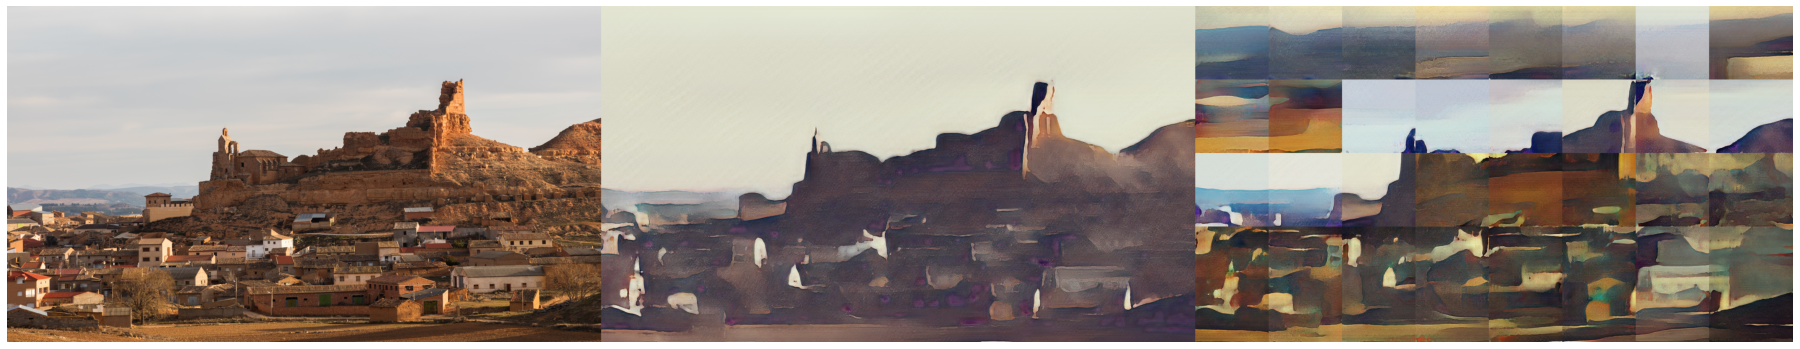

In [ ]:
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=0, shuffle=True)
# image = next(iter(data_loader))[0][0]
image = load_image('test_data/0557.png')

# render(stylize_image_mosaic(image, model, [1024]), size=(32, 32))
render(torch.cat((stylize_image(image, model, [1024]), stylize_image_mosaic(image, model, [1024])), 2), size=(32, 32))

In [ ]:
wandb.finish()

AttributeError: ignored

# Grid Transforms